# Anomaly Detection

In this module, we discuss the anomaly detection task. This is a unsupervised learning task - which means we do not use labels (targets) when training anomaly detection models. 

We will reuse the ETF SPY share prices, however, with its full range from 1993 until 2024. For each day, we still have the `Open`, `Close`, `Adj Close`, `High`, `Low`, and `Volume`. The task is to detect days with anomalous movements of prices.

## Loading and Visualizing the Data

In [2]:
%matplotlib notebook 

#this is call a "magic command" in Jupyter notebook. This command allows matplotlib figures to be interactive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_name = 'SPY_full.csv'
data_location = 'your bucket'
data = pd.read_csv(data_location + data_name)
data.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,24.840675,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,25.017363,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,25.070360,201300


In [5]:
data['Date'] = pd.to_datetime(data['Date'])
data.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,24.840675,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,25.017363,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,25.070360,201300


Plot the six features side-by-side. The y-axis represents the price, and the x-axis represents the date

<IPython.core.display.Javascript object>


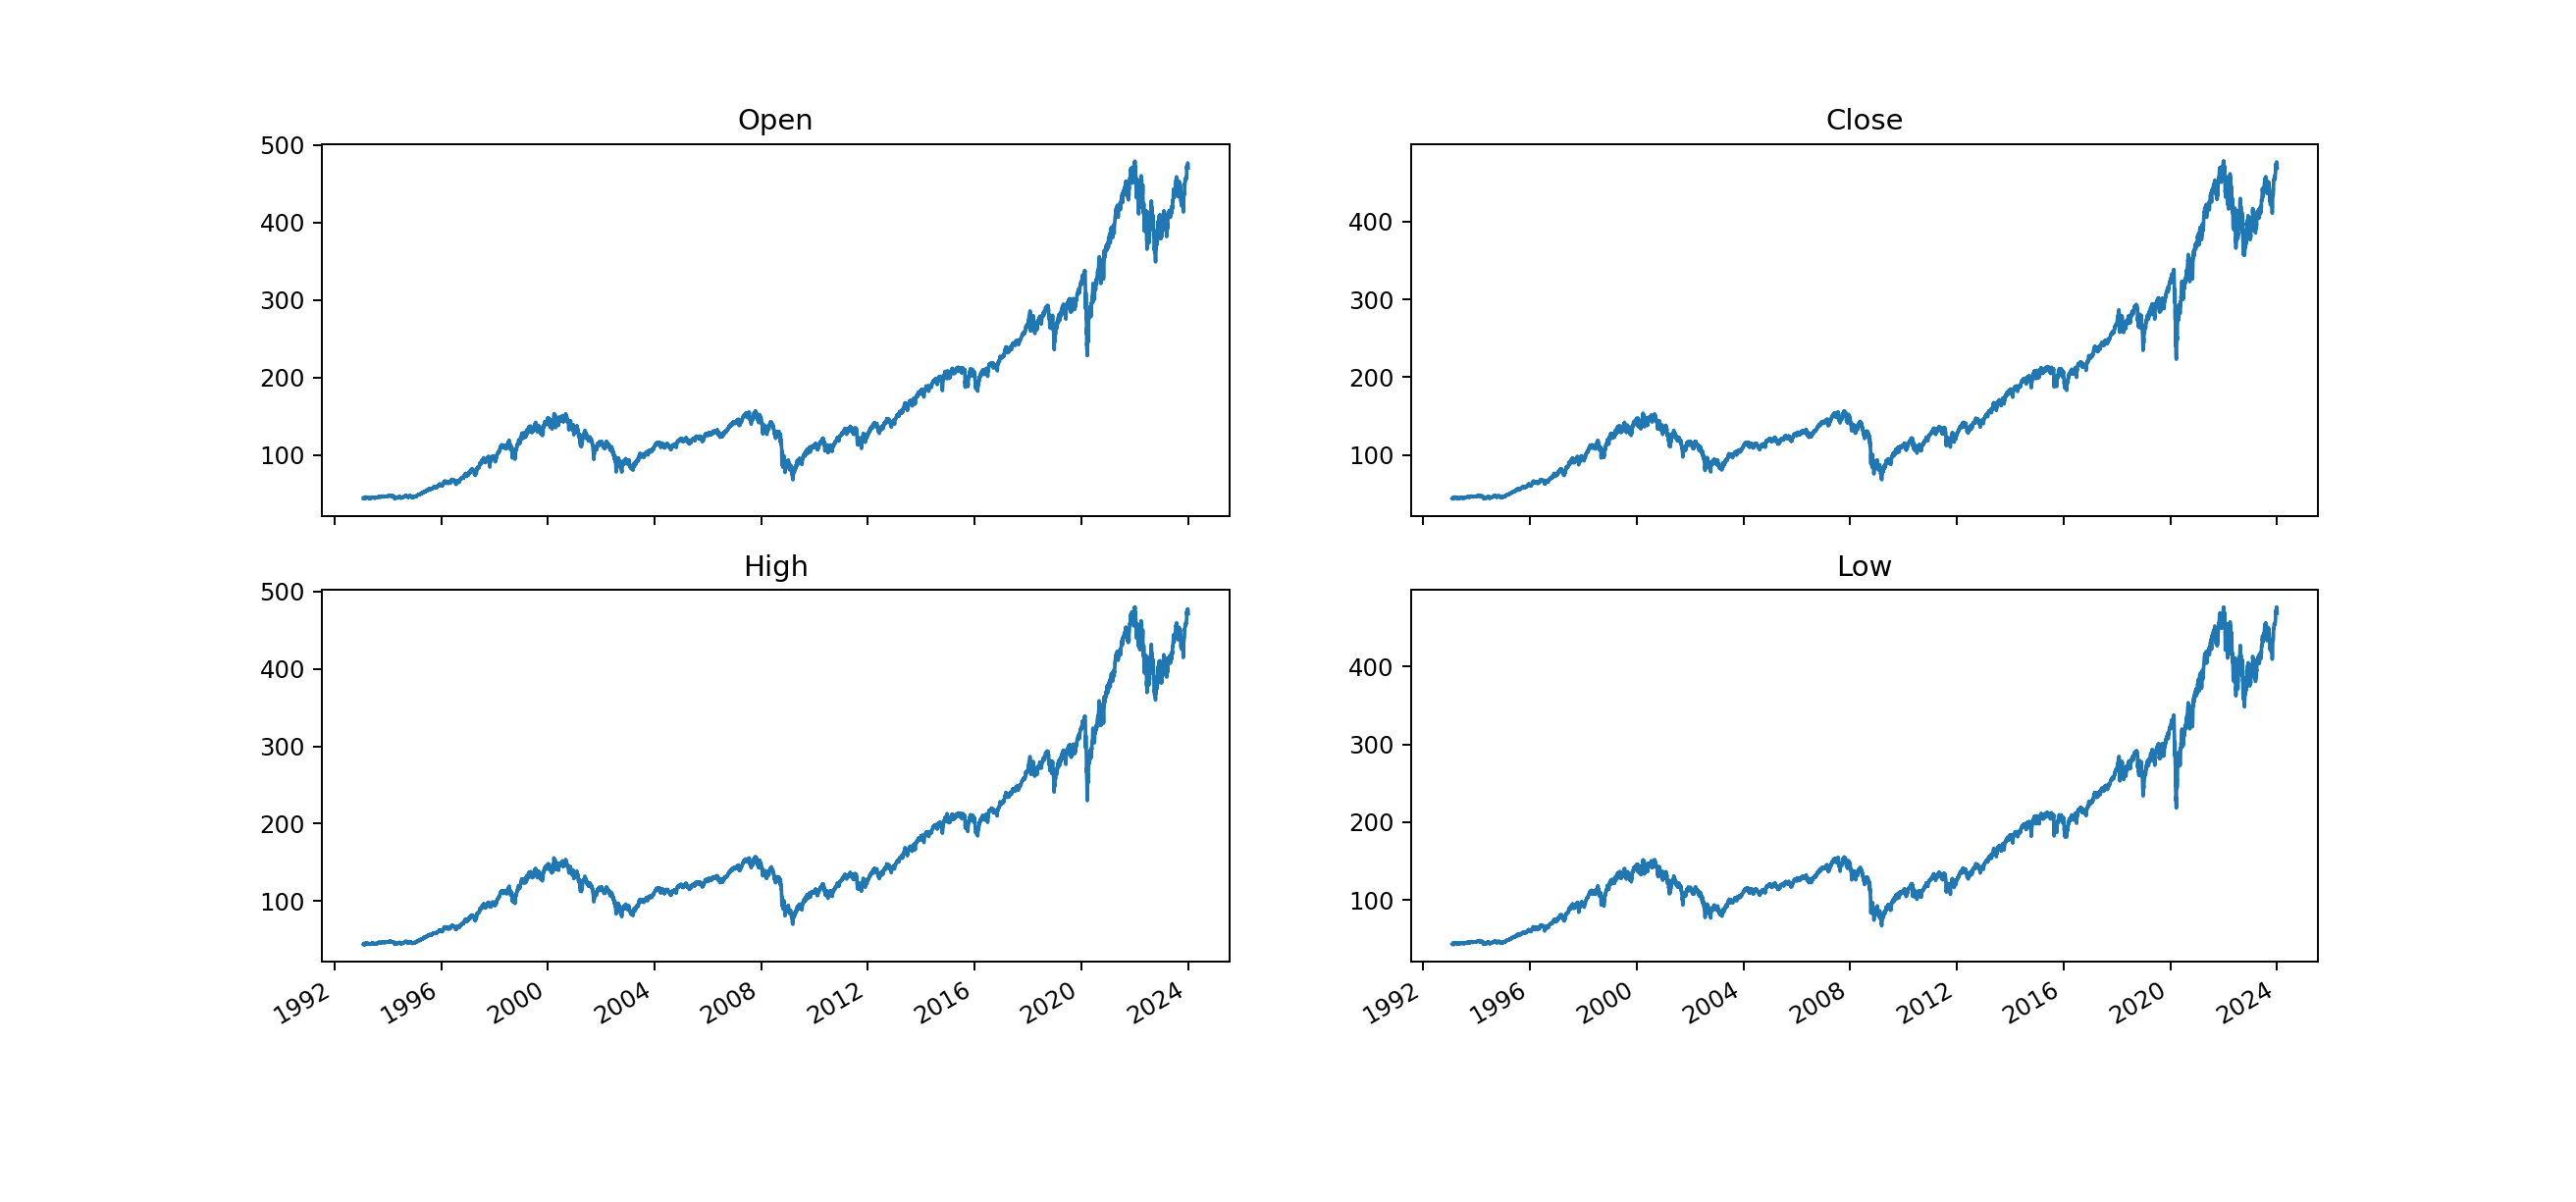

In [6]:
#we will draw four figures as subplots of the main figure
fig, axs = plt.subplots(2, 2, figsize=(15,7))

#subplot 1
axs[0, 0].plot(data['Date'], data['Open'])
axs[0, 0].set_title('Open')

#subplot 2
axs[0, 1].plot(data['Date'], data['Close'])
axs[0, 1].set_title('Close')

#subplot 3
axs[1, 0].plot(data['Date'], data['High'])
axs[1, 0].set_title('High')

#subplot 4
axs[1, 1].plot(data['Date'], data['Low'])
axs[1, 1].set_title('Low')

#automatically format the time axis
plt.gcf().autofmt_xdate()
plt.show()

We can also use a **candlestick** plot to illustrate stock data. This type of plot allows representing all four features (`Open`, `Close`, `High`, and `Low`) in a single plot.

<IPython.core.display.Javascript object>


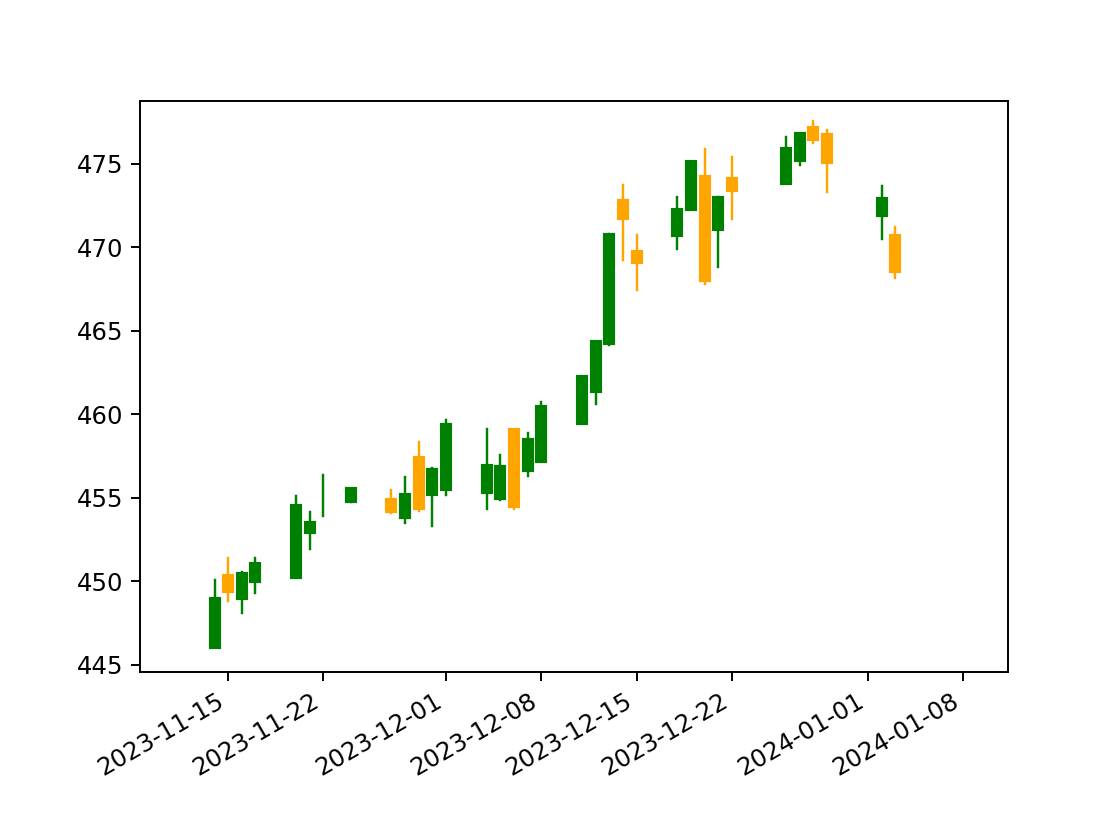

In [7]:
#split the data into up and down days
up = data.loc[data['Open'] <= data['Close'], :]
down = data.loc[data['Open'] > data['Close'], :]

#draw up days in orange
plt.plot([up['Date'],up['Date']],[up['Open'],up['Close']],color='green',linewidth=5)
plt.plot([up['Date'],up['Date']],[up['High'],up['Low']],color='green',linewidth=1)

#draw down days in green
plt.plot([down['Date'],down['Date']],[down['Open'],down['Close']],color='orange',linewidth=5)
plt.plot([down['Date'],down['Date']],[down['High'],down['Low']],color='orange',linewidth=1)

#rotate x ticks to read easier
plt.gcf().autofmt_xdate()
plt.show()

## Modeling Using Only Open and Close

For demonstration purpose, we first start using only two features. This allows us to plot the instances in a scatter plot and view how the anomalies are different from regular instances.

In [8]:
X = data[['Open','Close']]

### One-Class Support Vector Machine

In [9]:
from sklearn.svm import OneClassSVM
ocsvm = OneClassSVM(kernel='rbf',gamma=0.001,nu=0.01).fit(X)
y_ocsvm = ocsvm.predict(X)
np.unique(y_ocsvm, return_counts=True)

(array([-1,  1]), array([  80, 7708]))

<IPython.core.display.Javascript object>


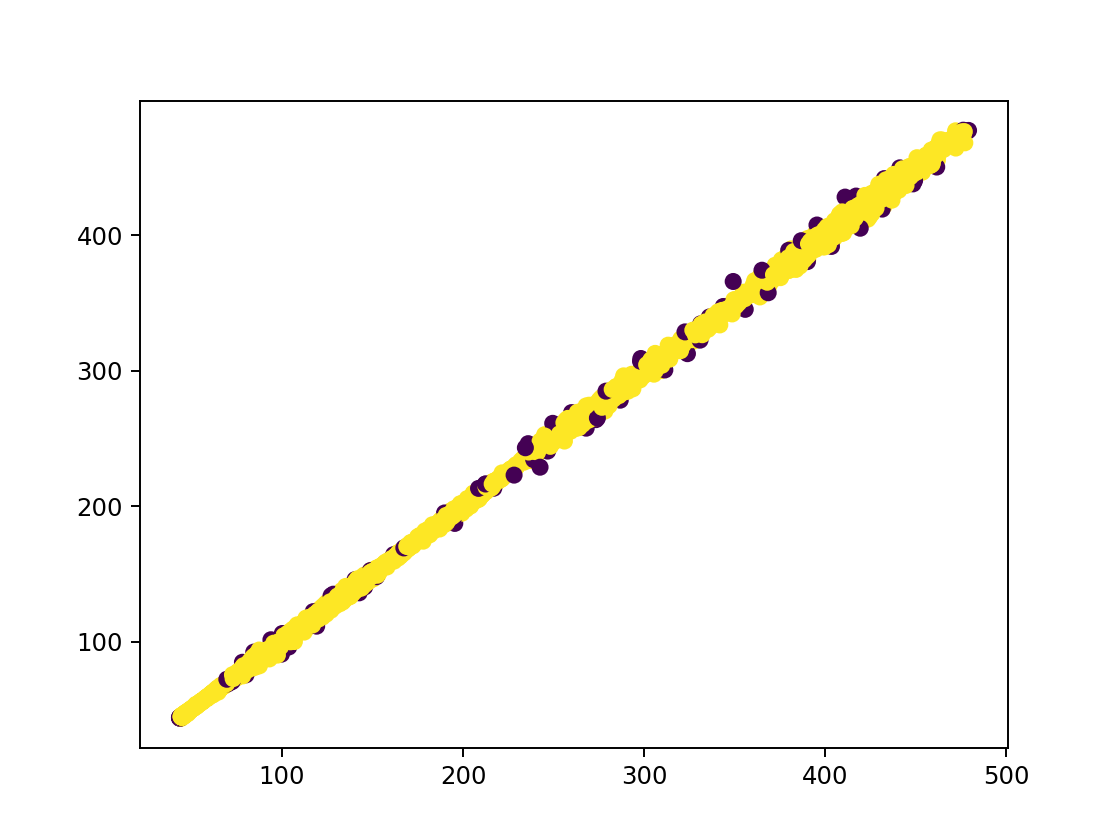

In [10]:
plt.scatter(X['Open'],X['Close'],c=y_ocsvm)
plt.show()

In [11]:
def candlestick(data, anomaly=None):
    #split the data into up and down days
    up = data.loc[data['Open'] <= data['Close'], :]
    down = data.loc[data['Open'] > data['Close'], :]

    #draw up days in orange
    plt.plot([up['Date'],up['Date']],[up['Open'],up['Close']],color='green',linewidth=5)
    plt.plot([up['Date'],up['Date']],[up['High'],up['Low']],color='green',linewidth=1)

    #draw down days in green
    plt.plot([down['Date'],down['Date']],[down['Open'],down['Close']],color='orange',linewidth=5)
    plt.plot([down['Date'],down['Date']],[down['High'],down['Low']],color='orange',linewidth=1)
    
    if anomaly is not None:
        ano = data.loc[anomaly == -1, :]
        plt.plot([ano['Date'],ano['Date']],[ano['Open'],ano['Close']],color='blue',linewidth=5)
        plt.plot([ano['Date'],ano['Date']],[ano['High'],ano['Low']],color='blue',linewidth=1)
    
    #rotate x ticks to read easier
    plt.gcf().autofmt_xdate()
    plt.show()

<IPython.core.display.Javascript object>


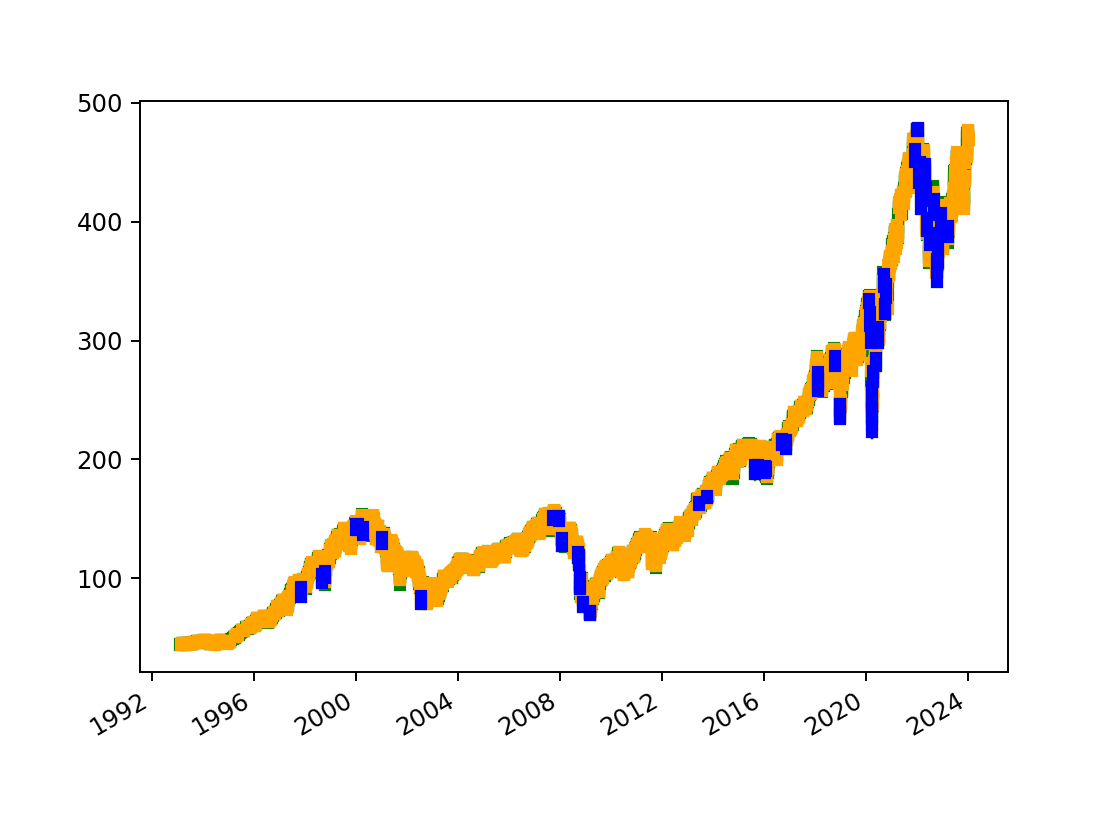

In [13]:
candlestick(data, y_ocsvm)

### Isolation Forest

In [14]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=0, contamination=0.01).fit(X)
y_if = clf.predict(X)

<IPython.core.display.Javascript object>


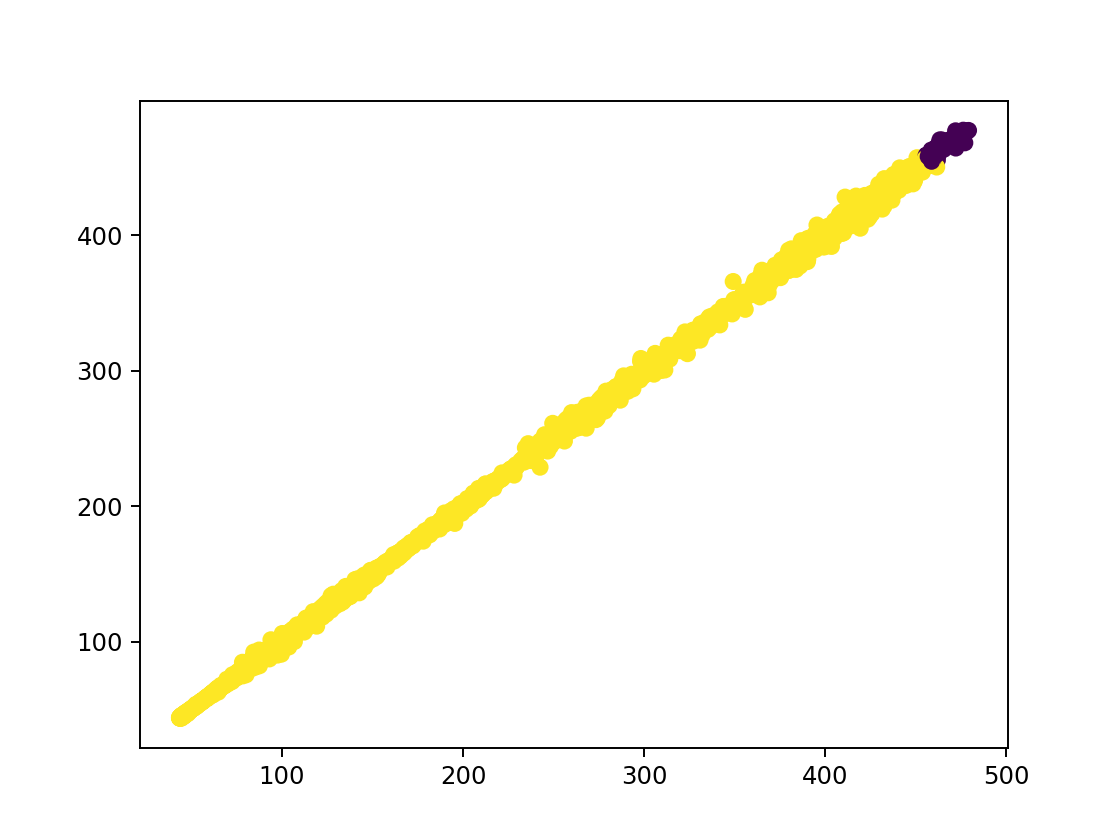

In [15]:
plt.scatter(X['Open'],X['Close'],c=y_if)
plt.show()

<IPython.core.display.Javascript object>


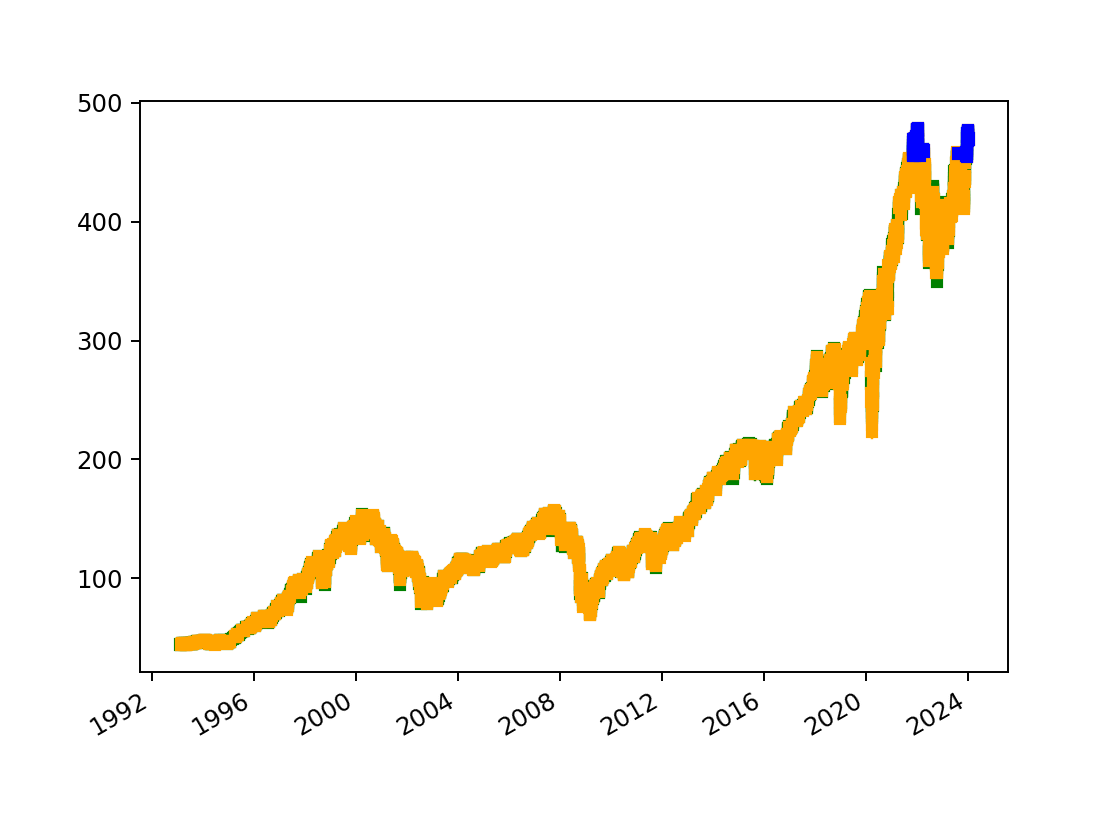

In [17]:
candlestick(data, y_if)

### Local Outlier Factor

In [31]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=20)
y_lof = lof.fit_predict(X)

<IPython.core.display.Javascript object>


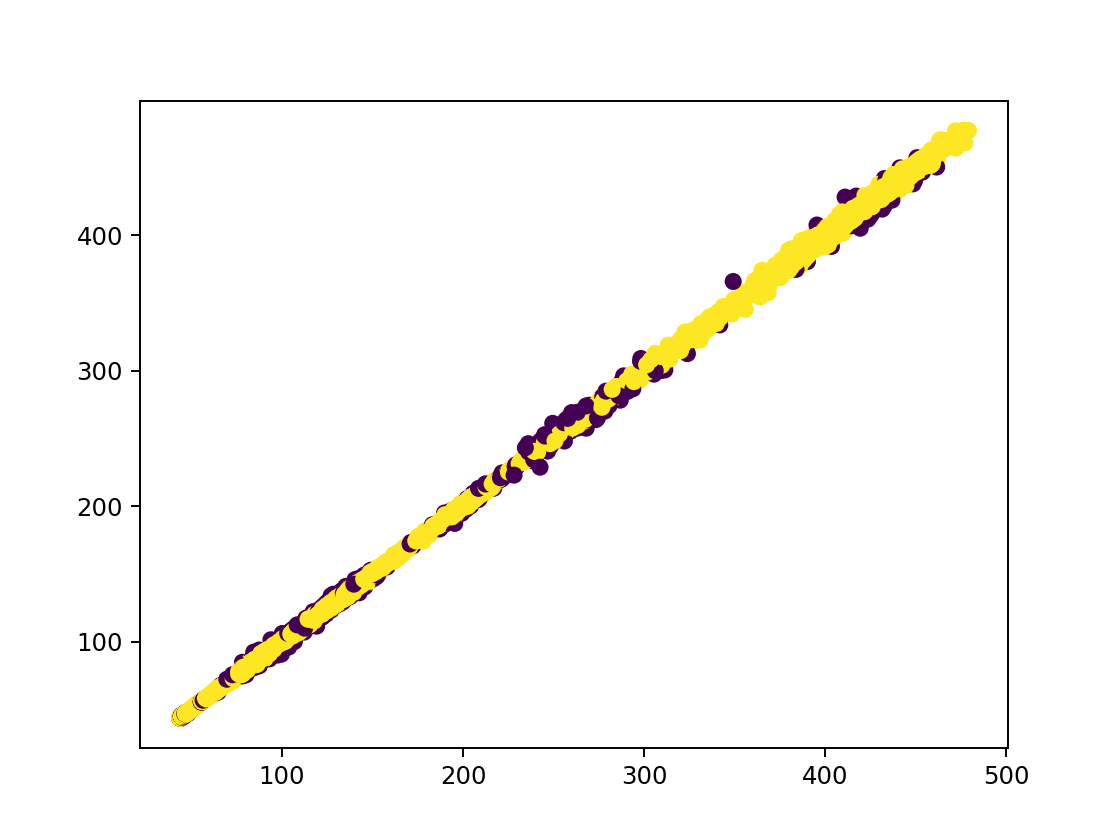

In [32]:
plt.scatter(X['Open'],X['Close'],c=y_lof)
plt.show()

<IPython.core.display.Javascript object>


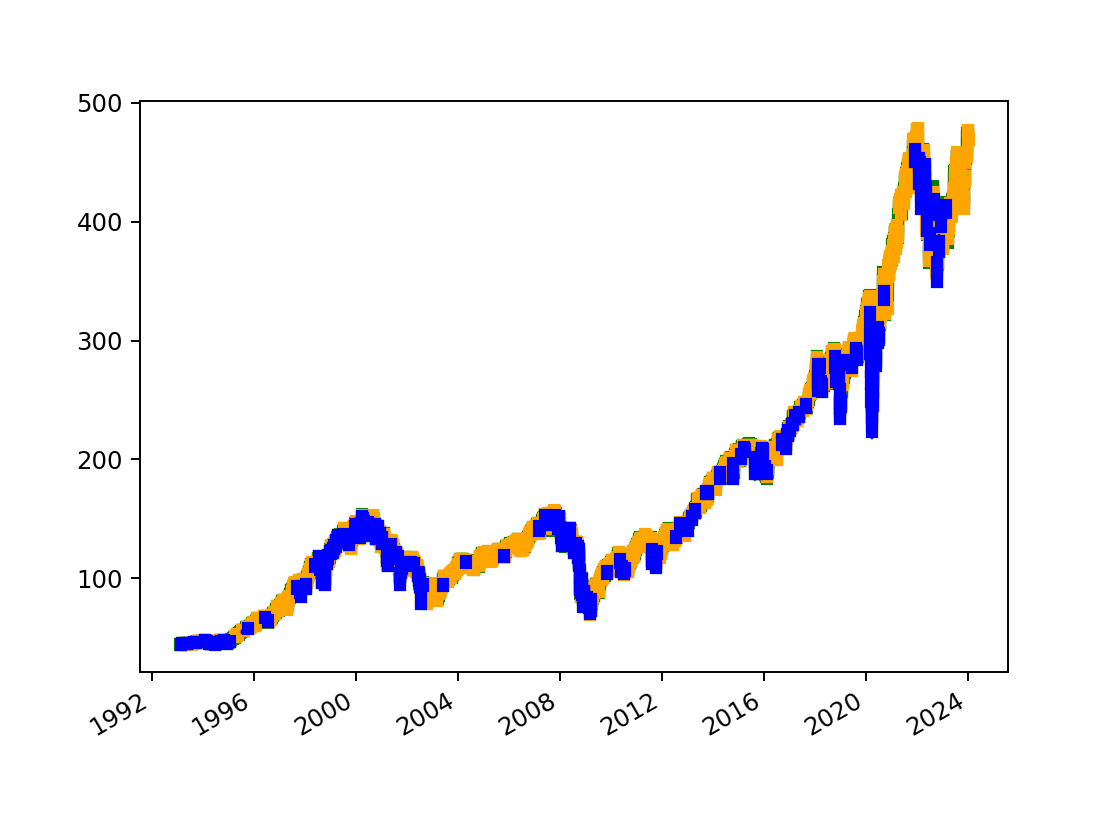

In [34]:
candlestick(data, y_lof)

## Modeling by Daily Differences

For data like the SPY ETF, we can see sometimes the instances are strongly correlated to time -- prices at the beginning of the ETF are much lower than prices at the end. This may cause issues to certain models, for example, isolation forest, as we can see earlier. Unfortunately, standardization does not solve this issue since the data is only rescale, and their differences through times are still the same. 

One way of solving this problem is to "difference" the data. Instead of modeling with the actual daily prices, we model with the <b>changes in prices</b>. As below, the differenced data is having a much better distribution than the original data.

In [22]:
X_diff = X.diff().loc[1:,:]
X_diff

,Open,Close
1,0.000000,0.312500
2,0.250000,0.093750
3,0.187500,0.468750
4,0.562500,0.187500
5,0.000000,-0.031250
...,...,...
7783,1.369995,0.860016
7784,1.440003,0.179992
7785,-0.390015,-1.380004
7786,-4.329986,-2.660004


<IPython.core.display.Javascript object>


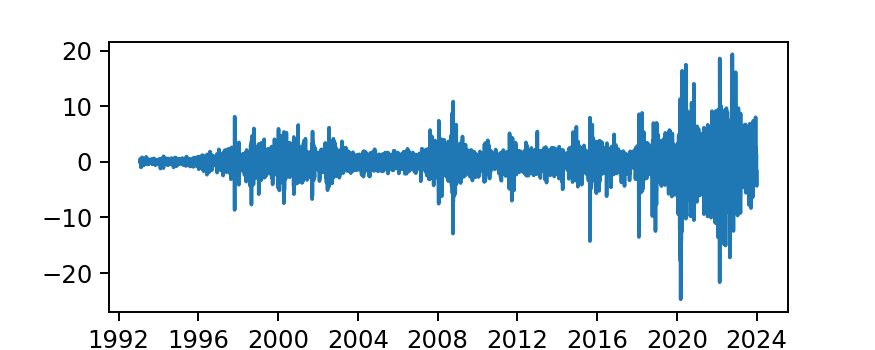

<IPython.core.display.Javascript object>


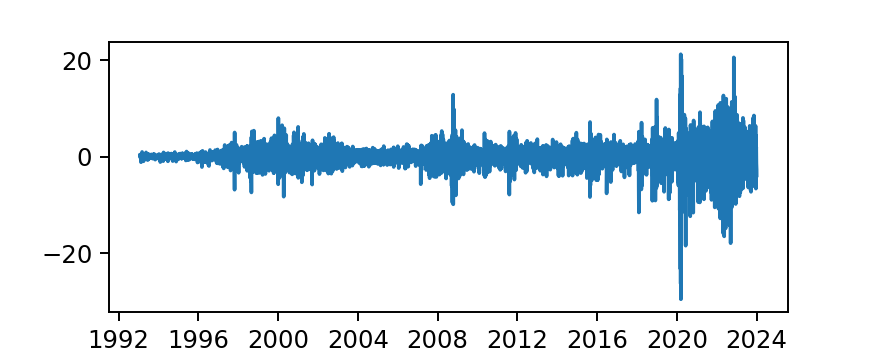

In [24]:
for col in ['Open', 'Close']:
    plt.figure(figsize=(5,2))
    plt.plot(data.loc[1:, 'Date'], X_diff[col])
    plt.show()

### One Class SVM

In [25]:
from sklearn.svm import OneClassSVM
ocsvm = OneClassSVM(gamma=0.001,nu=0.01).fit(X_diff)
y_ocsvm = ocsvm.predict(X_diff)
np.unique(y_ocsvm, return_counts=True)

(array([-1,  1]), array([  77, 7710]))

<IPython.core.display.Javascript object>


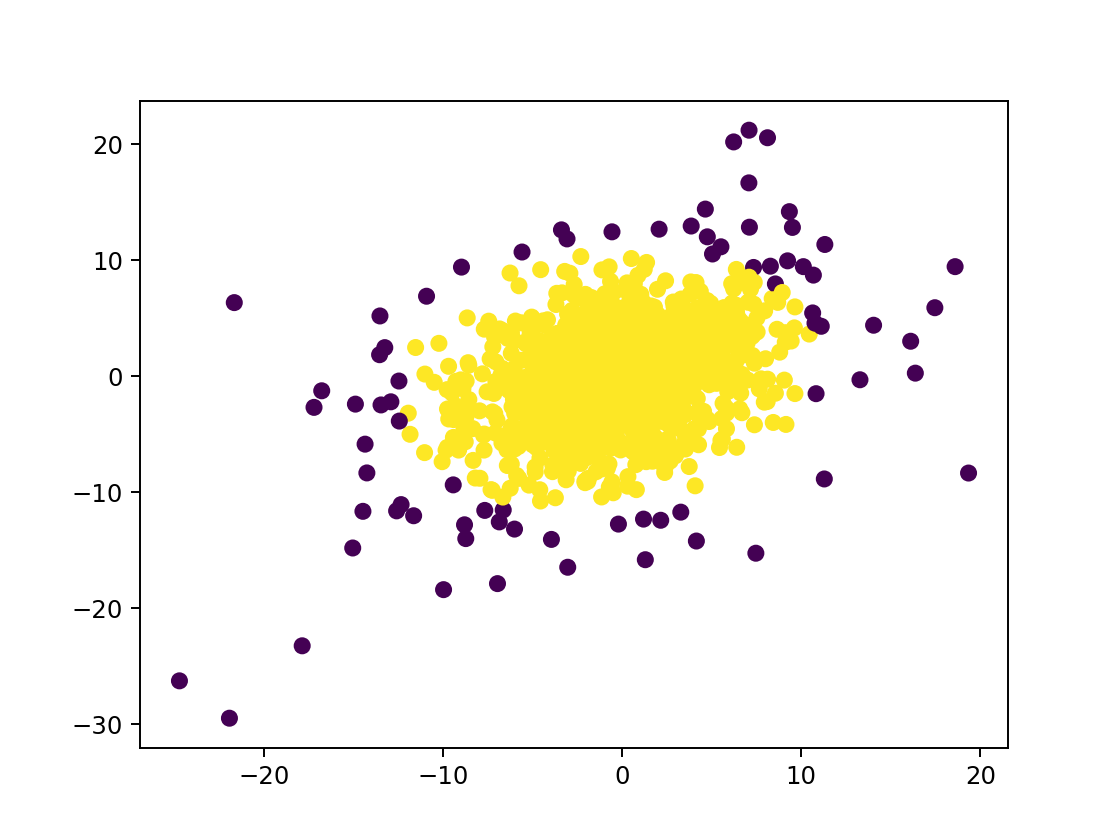

In [26]:
plt.scatter(X_diff['Open'],X_diff['Close'],c=y_ocsvm)
plt.show()

<IPython.core.display.Javascript object>


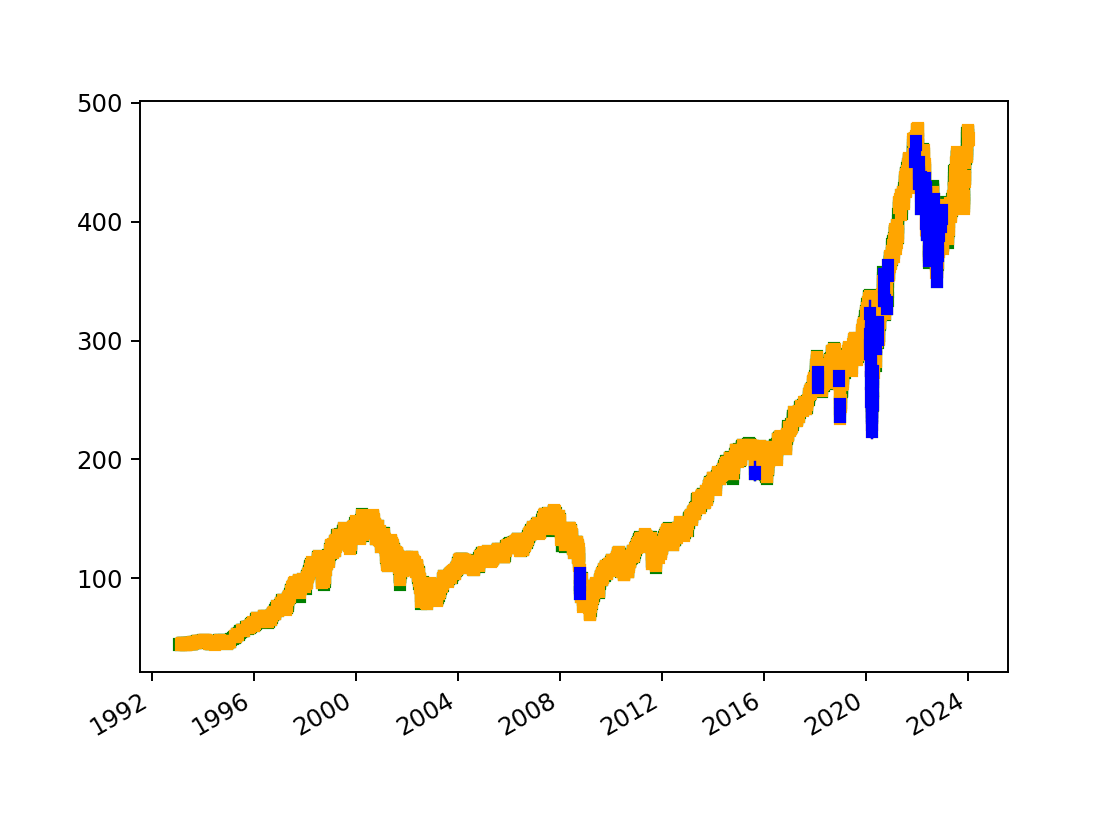

In [27]:
candlestick(data.loc[1:, :], y_ocsvm)

### Isolation Forest

In [28]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=0, contamination=0.005).fit(X_diff)
y_if = clf.predict(X_diff)

<IPython.core.display.Javascript object>


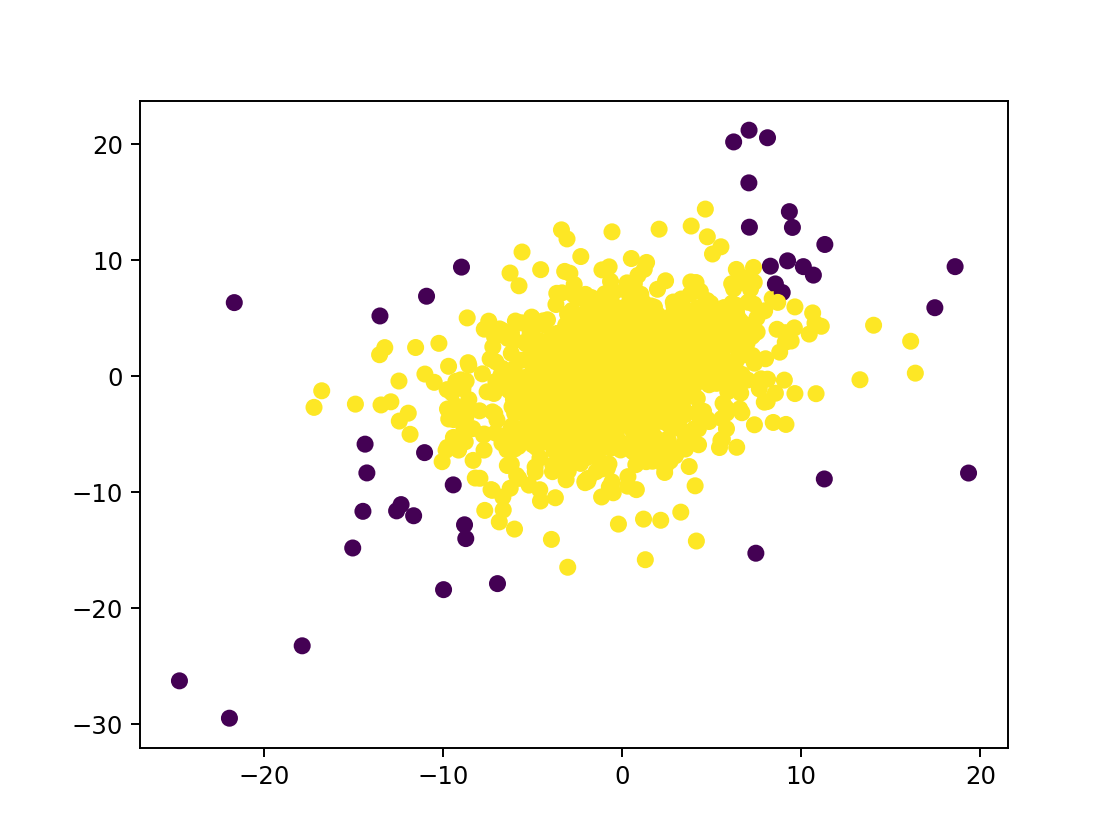

In [29]:
plt.scatter(X_diff['Open'],X_diff['Close'],c=y_if)
plt.show()

<IPython.core.display.Javascript object>


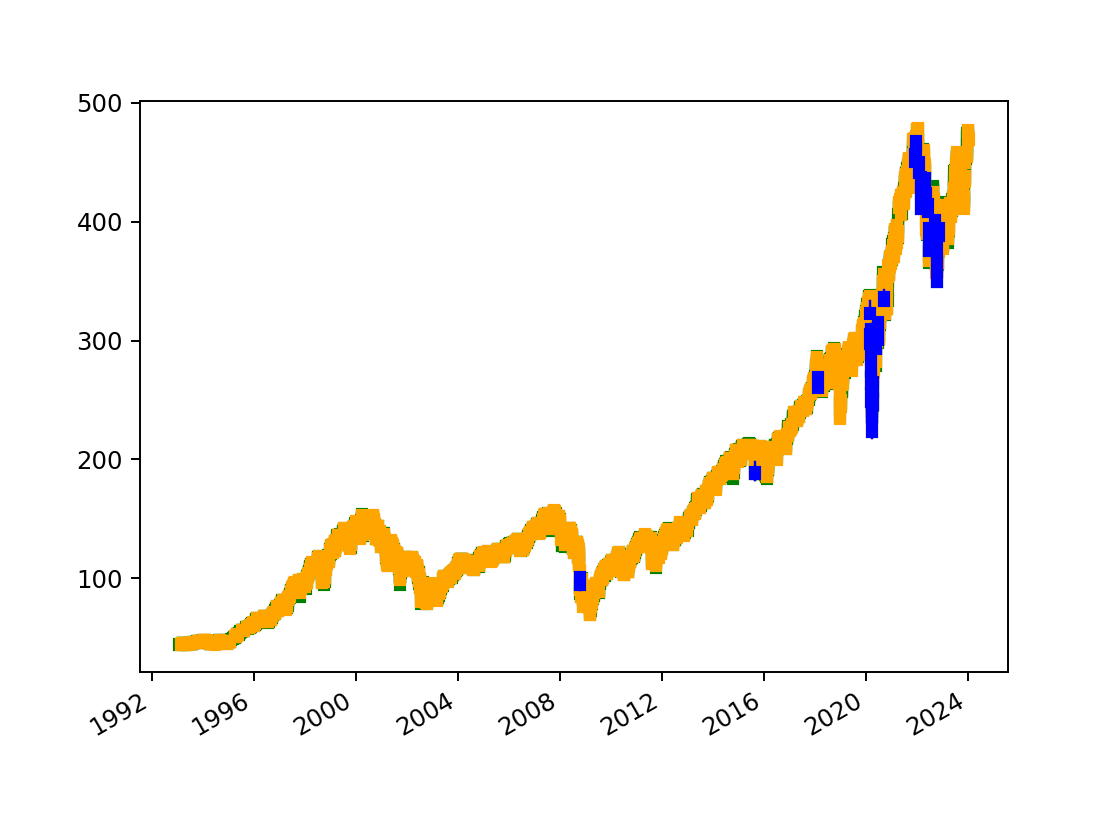

In [30]:
candlestick(data.loc[1:, :], y_if)

### Local Outlier Factor

In [35]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=20)
y_lof = lof.fit_predict(X_diff)

<IPython.core.display.Javascript object>


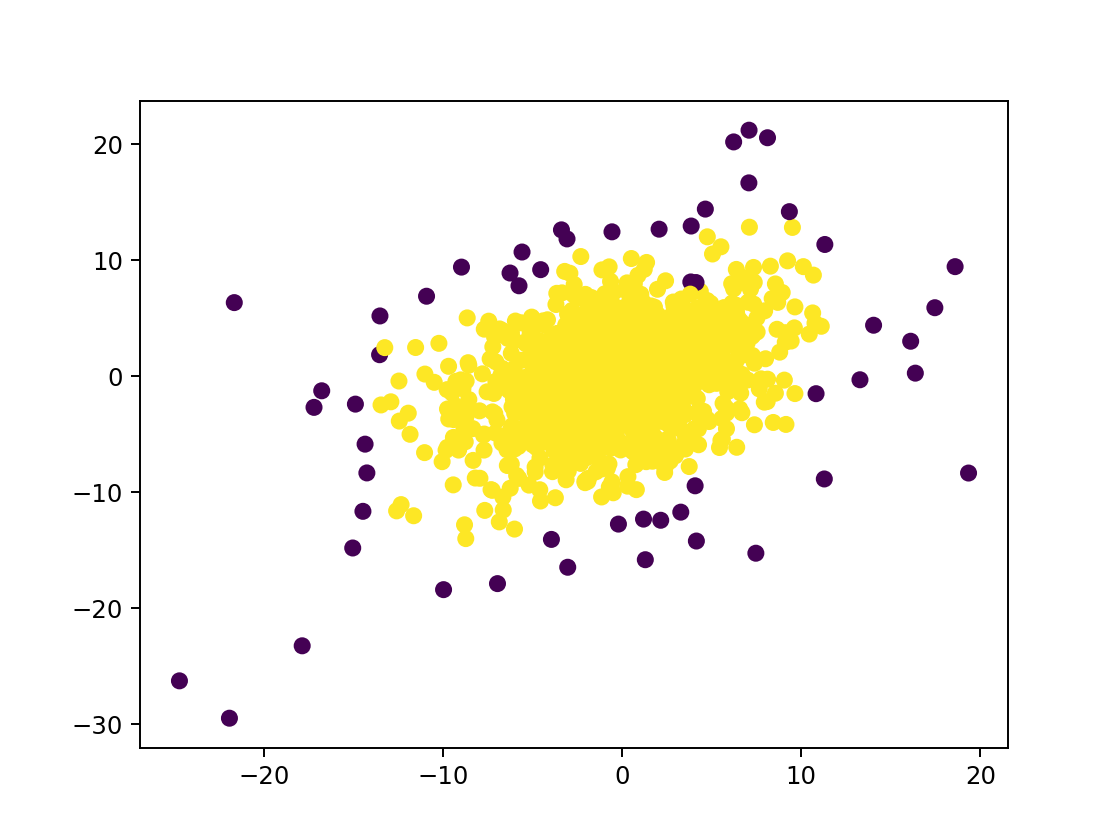

In [36]:
plt.scatter(X_diff['Open'],X_diff['Close'],c=y_lof)
plt.show()

<IPython.core.display.Javascript object>


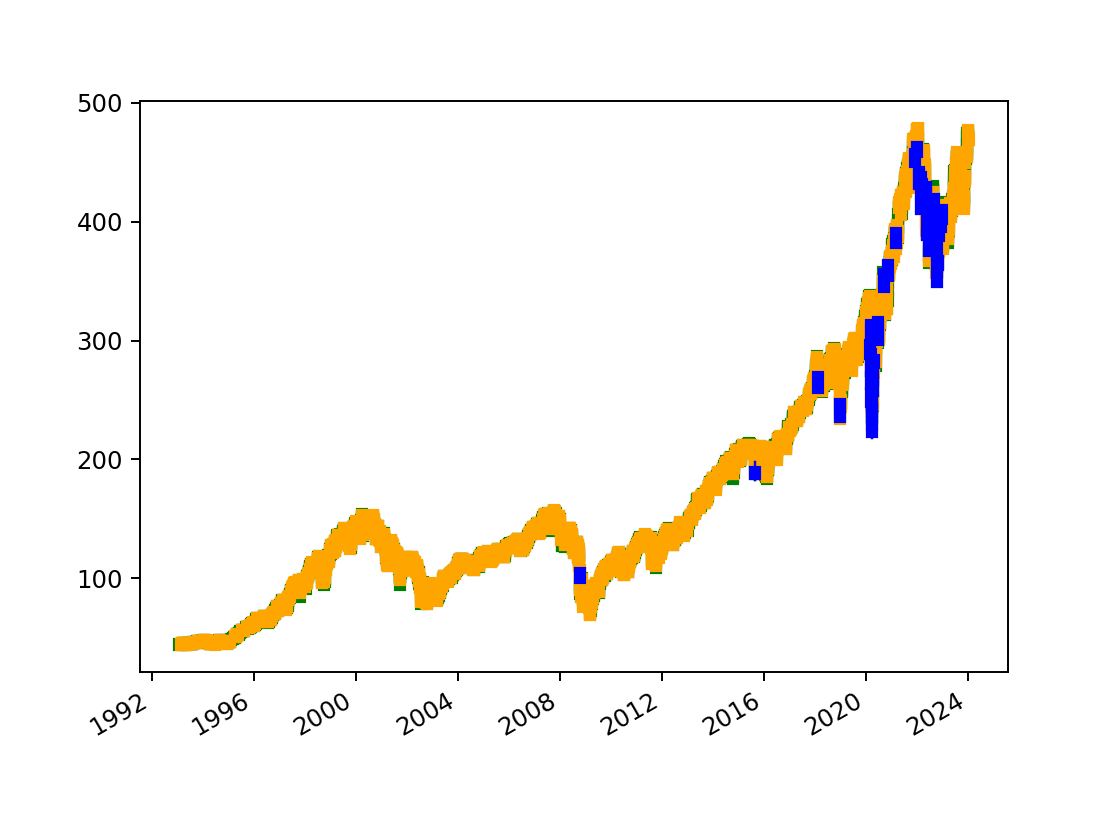

In [38]:
candlestick(data.loc[1:, :], y_lof)

## AWS Random Cut Forest

This is the SageMaker model for anomaly detection. The steps are similar to other AWS models, so we won't discuss again too much.

### Setting up Environment

In [39]:
import sagemaker
import boto3
import os

region = boto3.Session().region_name
role = sagemaker.get_execution_role()
sess = sagemaker.Session()
bucket = 'lle13-it7143'                           # S3 bucket name
prefix = 'anomaly-spy'                            # the folder to store your data in the S3 bucket

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### Build and Train the Model

Since hyperparameter tuning is not ideal, we choose a model

In [40]:
from sagemaker import RandomCutForest

# specify general training job information
rcf = RandomCutForest(
    role=role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    data_location=f"s3://{bucket}/{prefix}/",
    output_path=f"s3://{bucket}/{prefix}/output",
    num_samples_per_tree=512,
    num_trees=50,
)

rcf.fit(rcf.record_set(X_diff.values))

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: randomcutforest-2024-01-05-03-44-02-990


2024-01-05 03:44:03 Starting - Starting the training job...
2024-01-05 03:44:28 Starting - Preparing the instances for training.........
2024-01-05 03:45:44 Downloading - Downloading input data...
2024-01-05 03:46:08 Downloading - Downloading the training image..................
2024-01-05 03:49:19 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[01/05/2024 03:49:40 INFO 139631321876288] Reading default c

### Deploy Model
Like other AWS models, we need to deploy this one to an endpoint as well

In [41]:
rcf_inference = rcf.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: randomcutforest-2024-01-05-03-51-35-226
INFO:sagemaker:Creating endpoint-config with name randomcutforest-2024-01-05-03-51-35-226
INFO:sagemaker:Creating endpoint with name randomcutforest-2024-01-05-03-51-35-226


----------!

### Inference

Random Cut Forest outputs a score for each instance. The higher scores, the more likely the instances are anomalies. 

We can decide which instances are anomalies based on how far their scores are from the average score, for examples, 3.5 standard deviations as below

In [43]:
results = rcf_inference.predict(X_diff.values)
scores = np.array([d.label['score'].float32_tensor.values for d in results]).flatten()
score_mean = np.mean(scores)
score_std = np.std(scores)

score_cutoff = score_mean + 3.5*score_std
anomalies = np.ones(X_diff.shape[0])
anomalies[scores > score_cutoff] = -1

<IPython.core.display.Javascript object>


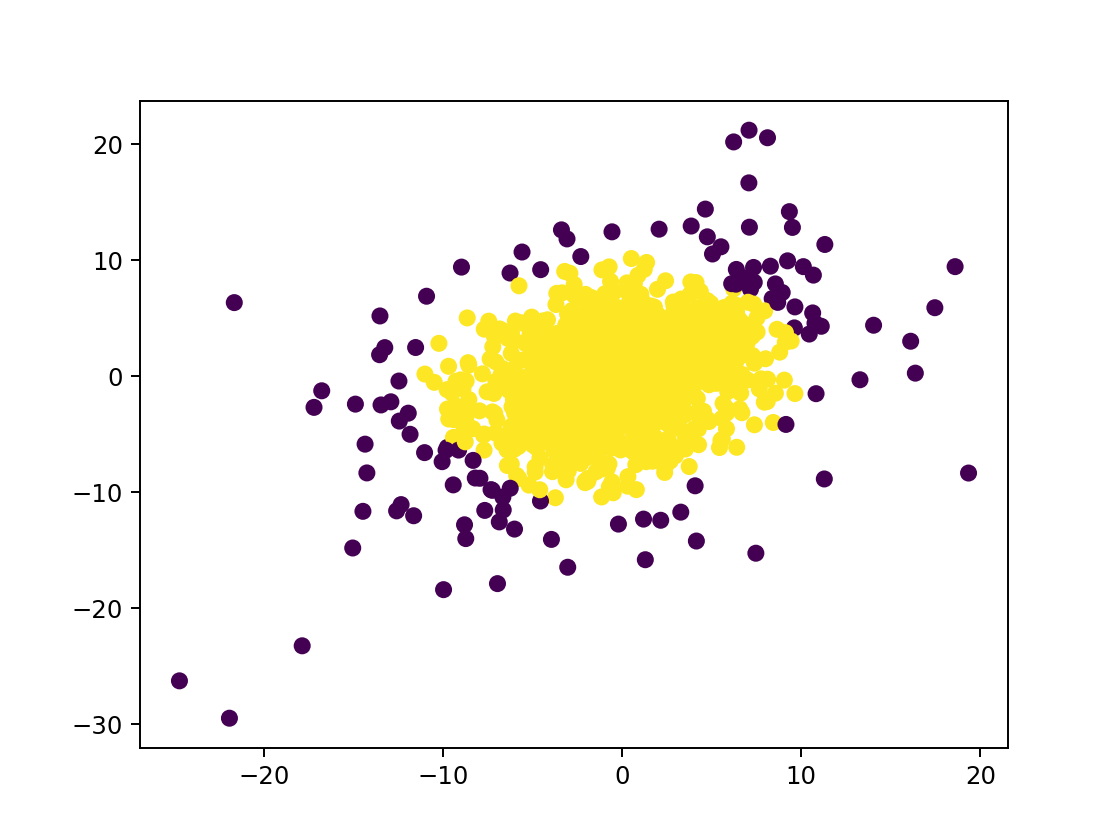

In [44]:
plt.scatter(X_diff['Open'],X_diff['Close'],c=anomalies)
plt.show()

<IPython.core.display.Javascript object>


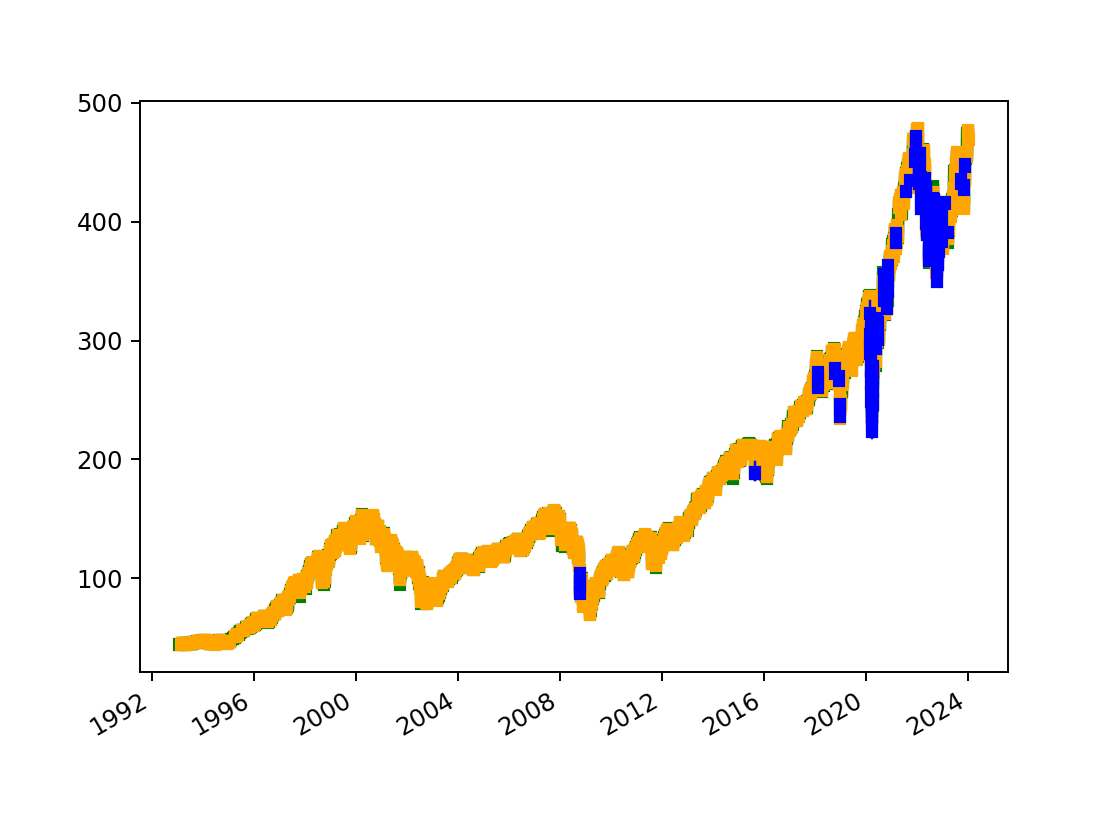

In [46]:
candlestick(data.loc[1:, :], anomalies)

## Cleaning up

**Don't forget to run this cell!**

In [ ]:
rcf_inference.delete_model()
rcf_inference.delete_endpoint(delete_endpoint_config=True)

## Comparing Anomalies Detected from All Models

It could be useful to see which instances get selected as anomalies by all four models

In [49]:
y_ocsvm.shape, y_if.shape, y_lof.shape, anomalies.shape

((7787,), (7787,), (7787,), (7787,))

In [50]:
true_ano = ((y_ocsvm == -1) & (y_if == -1) & (y_lof == -1) & (anomalies == -1))*1

The color is reversed compared to before

<IPython.core.display.Javascript object>


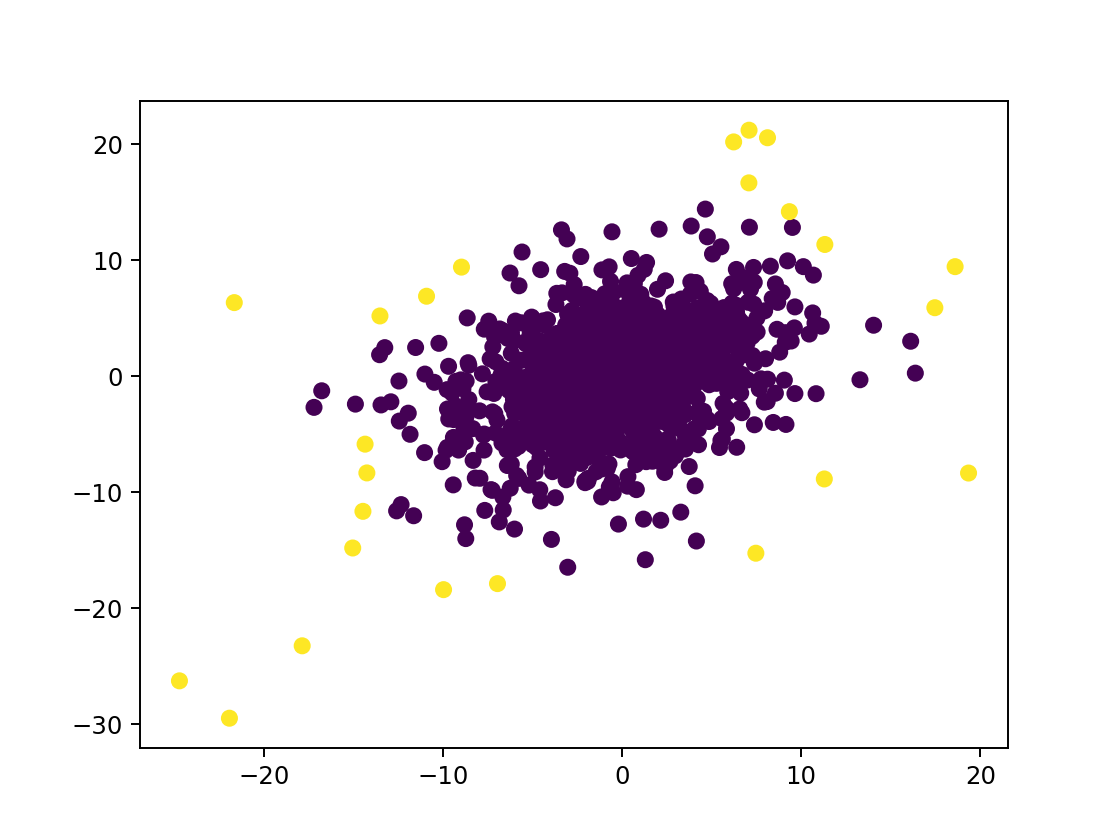

In [51]:
plt.scatter(X_diff['Open'],X_diff['Close'],c=true_ano)
plt.show()

<IPython.core.display.Javascript object>


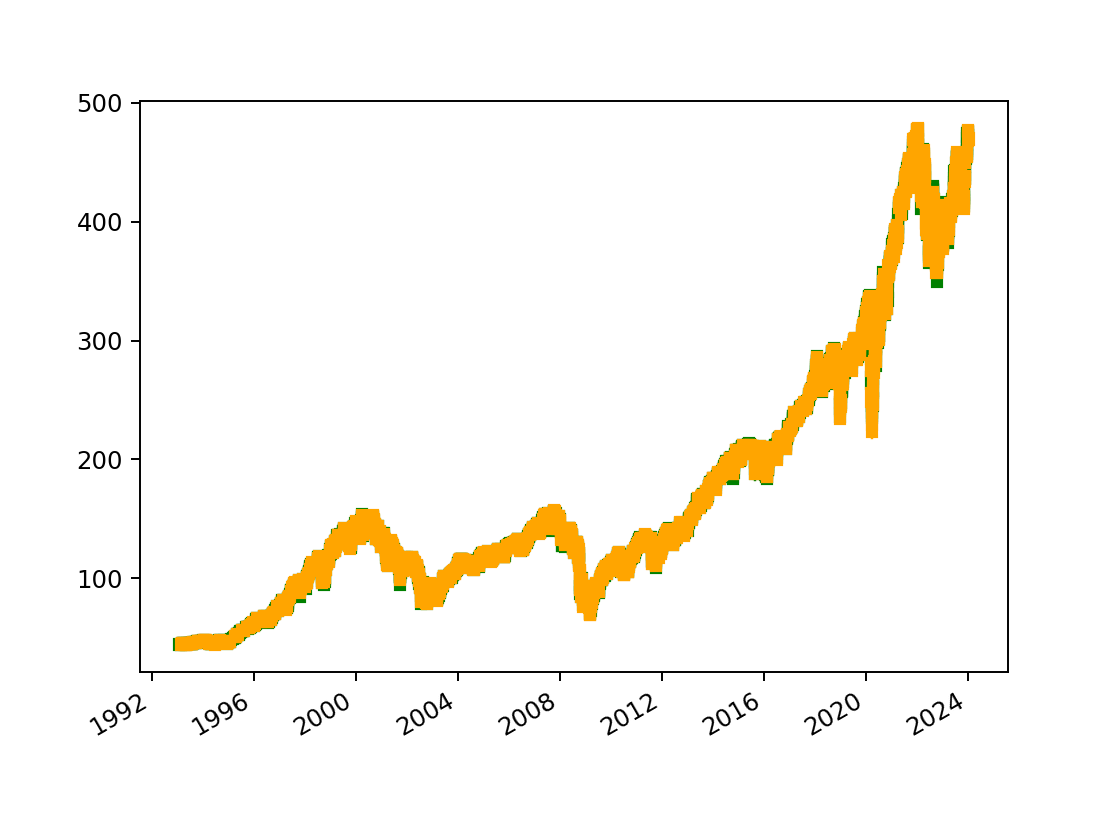

In [53]:
candlestick(data.loc[1:, :], true_ano)